In [453]:
%load_ext autoreload
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")

import jax.numpy as jnp
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
    
import utils
import plot
import distributions
import models
import flows
    
key = random.PRNGKey(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [454]:
from functools import partial
import kernels

In [455]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

In [456]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## Demo: Bayesian logistic regression

To demonstrate what we can do with the JAX backend, we'll implement Bayesian logistic regression applied to the classic Iris dataset.


First, let's import the Iris dataset and extract some metadata.



In [457]:
iris = datasets.load_iris()
features, labels = iris['data'], iris['target']

num_features = features.shape[-1]
num_classes = len(iris.target_names)

We can define the model using `tfd.JointDistributionCoroutine`. We'll put standard normal priors on both the weights and the bias term then write a `target_log_prob` function that pins the sampled labels to the data.

In [458]:
Root = tfd.JointDistributionCoroutine.Root
def model():
    w = yield Root(tfd.Sample(tfd.Normal(0., 1.),
                            sample_shape=(num_features, num_classes), name="w"))
    b = yield Root(tfd.Sample(tfd.Normal(0., 1.), sample_shape=(num_classes,), name="b"))
    logits = jnp.dot(features, w) + b
    _ = yield tfd.Independent(tfd.Categorical(logits=logits), reinterpreted_batch_ndims=1, name="labels") # this is why log_prob(sample) doesnt work: the batch dims are switched


dist = tfd.JointDistributionCoroutine(model)
def target_log_prob(*params):
    return dist.log_prob(params + (labels,))

In [459]:
# for intuition on how the model works:
key, subkey = random.split(key)
w = random.normal(subkey, shape=(num_features, num_classes))
key, subkey = random.split(key)
b = random.normal(subkey, shape=(num_classes, ))

dist.log_prob((w, b, labels))

DeviceArray(-595.33276, dtype=float32)

We sample from `dist` to produce an initial state for MCMC. We can then define a function that takes in a random key and an initial state, and produces 500 samples from a No-U-Turn-Sampler (NUTS). Note that we can use JAX transformations like `jit` to compile our NUTS sampler using XLA.

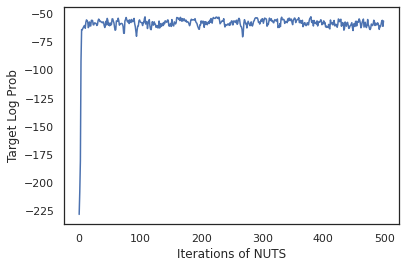

In [460]:
init_key, sample_key = random.split(random.PRNGKey(0))
init_params = tuple(dist.sample(seed=init_key)[:-1])

@jit
def run_nuts_chain(key, state):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
    return tfp.mcmc.sample_chain(500,
      current_state=state,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=0, # CHANGED
      seed=key)

states, log_probs = run_nuts_chain(sample_key, init_params)
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of NUTS')
plt.show()

Let's use our samples to perform Bayesian model averaging (BMA) by averaging the predicted probabilies of each set of weights.

First let's write a function that for a given set of parameters will produce the probabilities over each class. We can use `dist.sample_distributions` to obtain the final distribution in the model.

In [461]:
def classifier_probs(params):
    dists, _ = dist.sample_distributions(seed=random.PRNGKey(0),
                                       value=params + (None,))
    return dists[-1].distribution.probs_parameter()

We can `vmap(classifier_probs)` over the set of samples to get the predicted class probabilities for each of our samples. We then compute the average accuracy across each sample, and the accuracy from Bayesian model averaging.

In [462]:
all_probs = jit(vmap(classifier_probs))(states)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.9637333
BMA accuracy: 0.9866667


Looks like BMA reduces our error rate by almost a third!

# Same thing with Langevin dynamics

In [463]:
kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob, 1e-3)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


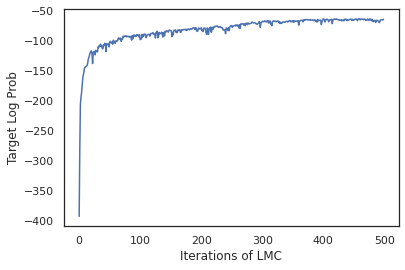

In [464]:
@jit
def run_lmc_chain(key, state):
    kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob, 1e-3)
    return tfp.mcmc.sample_chain(500,
      current_state=state,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=0, # CHANGED
      seed=key)

states, log_probs = run_lmc_chain(sample_key, init_params)
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of LMC')
plt.show()

# Use `vmap` to run multiple chains

In [488]:
n = 3
keys = random.split(key, n)
init_batch = dist.sample(n, seed=key)[:-1]

# NUTS
nuts_states, nuts_logp = vmap(run_nuts_chain)(keys, init_batch)

# LMC
lmc_states, lmc_logp = vmap(run_lmc_chain)(keys, init_batch)

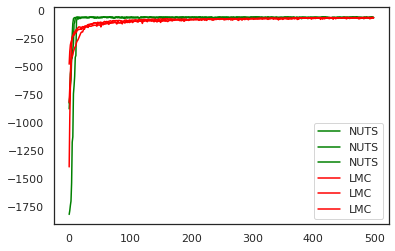

In [489]:
plt.plot(np.rollaxis(nuts_logp, 1), color="green", label="NUTS")
plt.plot(np.rollaxis(lmc_logp, 1), color="red", label="LMC")
plt.legend()

## Transform shapes into something my api can use

In [467]:
def logp(params_flat):
    return target_log_prob(*unravel(params_flat))

def ravel(params):
    flat, unravel = jax.flatten_util.ravel_pytree(params)
    return flat

def batch_ravel(batch):
    return vmap(ravel)(batch)

def batch_unravel(batch_flat):
    return vmap(unravel)(batch_flat)

Works like so:

In [468]:
params = dist.sample(seed=key)[:-1]
params_flat, unravel = jax.flatten_util.ravel_pytree(params)
# unravel(params_flat) == params

batch = dist.sample(3, seed=key)[:-1]
batch_flat = batch_ravel(batch)
# batch == batch_unravel(batch_flat)

In [505]:
def run_svgd(key, init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch = batch_ravel(init_batch)
    key, keya, keyb = random.split(key, 3)
    kernel_gradient = models.KernelGradient(target_logp=logp,
                                            key=keya)
    gradient = partial(kernel_gradient.gradient, scaled=True) # scale to match lambda_reg

    svgd_particles = models.Particles(key=keyb,
                                      gradient=gradient,
                                      init_samples=init_batch,
                                      learning_rate=1e-3,
                                      num_groups=1)
    for _ in range(500):
        svgd_particles.step(None)
        
    return batch_unravel(svgd_particles.particles.training), kernel_gradient, svgd_particles

In [487]:
def run_lmc(key, init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch = batch_ravel(init_batch)
    key, keya, keyb = random.split(key, 3)
    energy_gradient = models.KernelGradient(target_logp=logp, key=keya)

    svgd_particles = models.Particles(key=keyb,
                                      gradient=gradient,
                                      init_samples=init_batch,
                                      learning_rate=1e-2,
                                      num_groups=1)
    for _ in range(500):
        svgd_particles.step(None)
        
    return batch_unravel(svgd_particles.particles.training), kernel_gradient, svgd_particles

In [506]:
init_batch = dist.sample(100, seed=key)[:-1]
params, gradient, particles = run_svgd(key, init_batch)

In [507]:
particles.n_particles

100

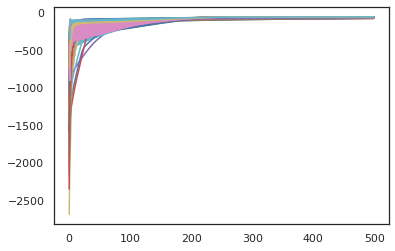

In [508]:
plt.plot(particles.rundata["training_logp"]);

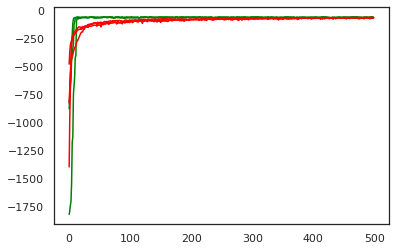

In [498]:
plt.plot(np.rollaxis(nuts_logp, 1), color="green", label="NUTS")
plt.plot(np.rollaxis(lmc_logp, 1), color="red", label="LMC")

In [509]:
# NUTS samples
all_probs = jit(vmap(classifier_probs))(states)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.8760267
BMA accuracy: 0.9266667


In [510]:
# SVGD samples
all_probs = jit(vmap(classifier_probs))(tuple(params))
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.96613336
BMA accuracy: 0.98


In [511]:
# random samples
all_probs = jit(vmap(classifier_probs))(tuple(dist.sample(100, seed=key)[:-1]))
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.32633334
BMA accuracy: 0.33333334
